<a href="https://colab.research.google.com/github/solobala/IvanGame/blob/master/pets1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача: Спрогнозировать пол питомца по его описанию

#№ 0. Импорт библиотек и пользовательские функции

In [1]:
!pip3 install ipython-sql 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.5 MB/s eta 0:00:00


In [2]:
!pip3 install psycopg2 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import psycopg2
from psycopg2 import sql

In [69]:
DATABASE = {
    'drivername': 'postgresql+psycopg2://',
    'host': '95.217.160.45',
    'port': '5634',
    'username': 'postgres',
    'password': SecretStr('sHiCpLUd0OIofgrvcdUnEt8rvYWjdBblPdMnnyDrb1LLK2lalAvAQ2ooIPgrcTMC'),
    'database': 'postgres'
}

In [5]:
conn = psycopg2.connect(
    dbname=DATABASE.get('database'), 
    user=DATABASE.get('username'), 
    password=DATABASE.get('password'), 
    host=DATABASE.get('host'), 
    port=DATABASE.get('port'))

In [6]:
cur = conn.cursor()

In [7]:
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")

In [8]:
%load_ext sql 
# а это загрузка установленного расширения

In [9]:
df = pd.read_sql('select id, name, description, gender from pets;', conn)

In [10]:
!pip install pymorphy2
!pip install pymorphy2-dicts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 61.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=2f6c85bb0ea45ba4ecc94e7c5ca9947b465ee2806a186c75677da123f6f180a2
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 52.1 MB/s eta 0:00:00


In [11]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [12]:
import nltk
nltk.download('punkt') # 
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [14]:
from nltk.tokenize import sent_tokenize # разбивает предложение на слова
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [15]:
# библиотека для определения принадлежности слова к русскому языку ( нужна для корректного определения рода клички)
!pip install fasttext-langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext-langdetect: filename=fasttext_langdetect-1.0.5-py3-none-any.whl size=7504 sha256=b82d3f7abc429aa364338db2d0d6816e4513434fc973b9da8cdebd581ae84e7a
  Stored in directory: /root/.cache/pip/wheels/e6/5b/5d/47e2fd5c2ff1028722739ce35f365e8f6eeb89ec97aa63e621
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393134 sha256=fd385d97c6398086ce1c7bd9f471e6aae2197525c4a5a78ab2d903844df59773
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext-langdetect fasttext


In [16]:
from ftlangdetect import detect

In [17]:
stop_words = stopwords.words('russian')
# Удаляем из списка стоп-слов слова, которые обладают родом - в частности, местоимения
for word in stop_words:
    if str(morph.parse(word)[0].tag.gender) in ['masc', 'femn']:
        stop_words.remove(word)

In [18]:
def check_lang(word):
    """
    Вспомогательная функция для определения рода слова
    в случае принадлежности его к русскому языку
    """
    word=word.lower()
    female_exceptions=['роза', 'лайма','шерри', 'кира','черри', 'дейзи', 'тейзи', 
                       'злата','хлоя','рада', 'рала', 'лола','нюрочка', 'коко', 'дина',
                      'клякса', 'лисса', 'уна', 'герда', 'жужа','афина', 'пралине', 'лотта',
                      'люси', 'боня', 'лея', 'ася', 'бася', 'белка', 'ютв', 'сима', 'мира', 'моника',
                      'мотя', 'вита']
    male_exceptions=['хаммер', 'альф', 'денди','кунжут','мухтар','риччи', 'бим']
    language = detect(word, low_memory=False)['lang']
    if word in female_exceptions:
        return 'femn'
    elif word in male_exceptions:
        return 'masc'
    else:
        if (language != "ru"):
            return 'neut'
        else:
            return morph.parse(word)[0].tag.gender

In [19]:
df['sex_name']=df['name'].apply(check_lang)

In [20]:
def get_gender(text):
    """
    Вспомогательная функция.
    Входной параметр text
        - Разбивает text на предложения.
        - Удаляет все символы кроме букв
        - Делит предложения на токены
        - при отсутствии токена в списке стоп-слов определяется его часть речи и род.
        все это выполняется для  тех частей речи, которые обладают родом ('parts')
        - для каждой части речи в 'parts' определяется наиболее часто встречающийся род
    Результат работы - словарь, где ключи - parts, а значения - наиболее часто встречающиеся рода
    """
   
    genders=dict()
    result = dict()
    token_parts=dict()

    parts=['NOUN', 'ADJF', 'ADJS', 'NPRO', 'PRTS']

    for part in parts:
        token_parts[part]=[]
        
    sentences = nltk.sent_tokenize(text, language="russian")
    
    for sentence in sentences:
        sentence_ = re.sub(r"[^А-Яа-яёЁ ]","", sentence) # удалим все кроме букв
        tokens = nltk.word_tokenize(sentence_) # делим предложение на слова

        for item in tokens:
            if  item not in stop_words:
                
                for part in parts:
                    if  (str(morph.parse(item)[0].tag.POS)==part):
                        res = check_lang(item)
                        token_parts[part].append(res)

                        break
            else:
                pass

    for part in parts:
        genders[part] = Counter(token_parts[part])
        result[part] = genders[part].most_common(1)[0][0] if genders[part]!=Counter() else 'neut'
    return result 

In [21]:
# результаты разбора description помещаются во вспомогательное поле result
df['result']= df['description'].apply(get_gender)

In [22]:
# Разбиваем вспомогательное поле кesult на отдельные колонки по частям речи
df['sex_noun']=df['result'].apply(lambda x: x['NOUN'])
df['sex_adjf']=df['result'].apply(lambda x: x['ADJF'])
df['sex_adjs']=df['result'].apply(lambda x: x['ADJS'])
df['sex_npro']=df['result'].apply(lambda x: x['NPRO'])
df['sex_prts']=df['result'].apply(lambda x: x['PRTS'])

In [23]:
# при отсутствии в тексте каких-либо частей речи появляются nan. Заменяем их на 'neut'
df.loc[df[df['sex_noun'].isna()].index ,'sex_noun'] = 'neut' 
df.loc[df[df['sex_adjf'].isna()].index ,'sex_adjf'] = 'neut' 
df.loc[df[df['sex_adjs'].isna()].index ,'sex_adjs'] = 'neut' 
df.loc[df[df['sex_npro'].isna()].index ,'sex_npro'] = 'neut'
df.loc[df[df['sex_prts'].isna()].index ,'sex_prts'] = 'neut'

In [24]:
# поскольку выполняется обучение модели, то убираем из датасета неразмеченную часть 
# ( там, где gender='unknown')
data=df[df['gender']!='unknown']

In [25]:
y=data['gender']
X=data[['sex_name','sex_noun','sex_adjf','sex_npro', 'sex_adjs', 'sex_prts' ]]

In [26]:
# Произведем Label-кодирование признака 'gender'
le = LabelEncoder()
le.fit(y)
y = pd.Series(data=le.transform(y))

In [27]:
categorical_features = ['sex_name','sex_noun','sex_adjf','sex_npro', 'sex_adjs', 'sex_prts']
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
       
        ("cat", categorical_transformer, categorical_features),
    ]
) 

In [28]:
# Настройка параметров оценивания алгоритма
random_seed=0
num_folds = 10
n_iter = 1000
n_estimators = 100
scoring = 'f1'
target_names = ['male', 'female']

In [29]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=1000, random_state=random_seed))]
)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.967


In [31]:
# Выполним оптимизацию
param_grid = {
  
    "preprocessor__cat__selector__percentile": [10, 30, 50, 55, 70, 80],
    "classifier__C": [0.1, 1.0, 10,50, 100, 200,],
}

search_cv = RandomizedSearchCV(clf, param_grid, n_iter=10, random_state=random_seed)

In [32]:
search_cv.fit(X_train, y_train)

print("Best params:")
print(search_cv.best_params_)

Best params:
{'preprocessor__cat__selector__percentile': 50, 'classifier__C': 50}


In [33]:
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[
    [
        "mean_test_score",
        "std_test_score",
      
        "param_preprocessor__cat__selector__percentile",
        "param_classifier__C",
    ]
].head(5)

,mean_test_score,std_test_score,param_preprocessor__cat__selector__percentile,param_classifier__C
1,0.969442,0.004638,50,50
5,0.968827,0.004488,55,10
6,0.968827,0.004107,70,1.0
8,0.968827,0.004107,80,1.0
2,0.968673,0.004271,70,10


In [34]:
print(
    "accuracy of the best model from randomized search: "
    f"{search_cv.score(X_test, y_test):.3f}"
)

accuracy of the best model from randomized search: 0.967


In [35]:
predictions = search_cv.predict(X_test)
pred_proba = search_cv.predict_proba(X_test)
precision_score(y_test, predictions)

0.9632701421800948

In [36]:
recall_score(y_test, predictions)

0.9736526946107784

In [37]:
f1_score(y_test, predictions)

0.9684335914234663

In [38]:
# смотрим разницу факта и прогноза
result = pd.DataFrame([y_test.to_numpy(), predictions]).T
ind=result[result[0]!=result[1]].index
data.iloc[ind]

,id,name,description,gender,sex_name,result,sex_noun,sex_adjf,sex_adjs,sex_npro,sex_prts
14,22573,Сэм,"Скромный и ласковый, нежный, добрый малыш Сэм!...",male,masc,"{'NOUN': 'masc', 'ADJF': 'masc', 'ADJS': 'masc...",masc,masc,masc,masc,masc
19,23039,Злата,Нашей Злате не нужно носить золото – она сама ...,female,femn,"{'NOUN': 'femn', 'ADJF': 'neut', 'ADJS': 'neut...",femn,neut,neut,femn,femn
29,22544,Тарзан,Тарзан – обладатель мультяшной внешности и мил...,male,neut,"{'NOUN': 'neut', 'ADJF': 'masc', 'ADJS': 'neut...",neut,masc,neut,masc,masc
70,22589,Черри,"Москва\nДевочка Черри, для своих Черешня.\n\nС...",female,femn,"{'NOUN': 'femn', 'ADJF': 'femn', 'ADJS': None,...",femn,femn,neut,femn,femn
115,22482,Альма,Москва МО\n\nВы только посмотрите какая красот...,female,femn,"{'NOUN': 'femn', 'ADJF': 'femn', 'ADJS': 'femn...",femn,femn,femn,femn,femn
116,22611,Егор,"Из-за леса, из-за гор появляется ЕГОР♥️\nПрост...",male,masc,"{'NOUN': 'femn', 'ADJF': 'masc', 'ADJS': 'neut...",femn,masc,neut,masc,neut
206,22669,Клим,"Небольшой, ласковый и очень ориентированный на...",male,neut,"{'NOUN': 'masc', 'ADJF': 'masc', 'ADJS': 'neut...",masc,masc,neut,neut,neut
208,22671,Тейзи,Ищет дом и любящую семью очаровательная девочк...,female,femn,"{'NOUN': 'femn', 'ADJF': 'femn', 'ADJS': 'femn...",femn,femn,femn,neut,femn
215,22678,Мишель,"Мишель 2 года, рост 50 см 17 кг\nМишелька особ...",male,masc,"{'NOUN': 'masc', 'ADJF': 'femn', 'ADJS': 'masc...",masc,femn,masc,masc,masc
228,22690,Герой,"Герой, 4 года\nВ нём явно прослеживаются корни...",male,neut,"{'NOUN': 'masc', 'ADJF': 'masc', 'ADJS': 'masc...",masc,masc,masc,masc,masc


In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (c) http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.961 0.039]
 [0.026 0.974]]


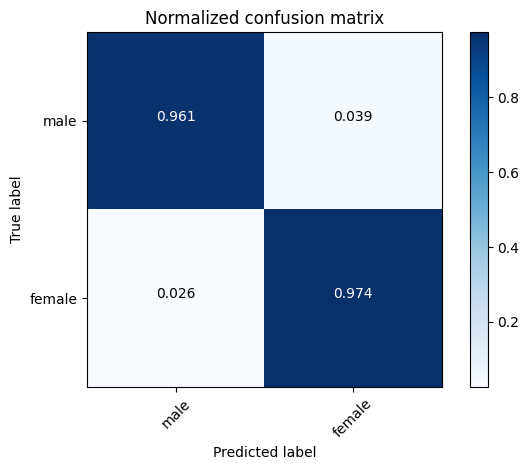

In [41]:
cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=3)
class_names = ['male', 'female']
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [42]:
print(f"Classification report LogisticRegression\n")
print('====================================================================')

print(f"{classification_report(y_test, predictions, target_names=target_names)}\n")

Classification report LogisticRegression

              precision    recall  f1-score   support

        male       0.97      0.96      0.97       793
      female       0.96      0.97      0.97       835

    accuracy                           0.97      1628
   macro avg       0.97      0.97      0.97      1628
weighted avg       0.97      0.97      0.97      1628




In [43]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.0 MB/s eta 0:00:00


In [44]:
from catboost import CatBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  BaggingClassifier
from sklearn.ensemble import  StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold


In [45]:
# Формирование списка алгоритмов
models = []
models.append(('LR', LogisticRegression(random_state=random_seed)))
models.append(('DTC', DecisionTreeClassifier(random_state=random_seed)))
models.append(('RFC', RandomForestClassifier(random_state=random_seed)))
models.append(('BGC', BaggingClassifier(random_state=random_seed)))
models.append(('SCC', StackingClassifier(
     [
                                      ('DTS', DecisionTreeClassifier(random_state=random_seed)),
                                      ('RFC',  RandomForestClassifier(random_state=random_seed)),
                                     ],  
                                      LinearSVC(C=1, random_state=random_seed) 
)))
models.append(('GBC', GradientBoostingClassifier(random_state=random_seed)))
models.append(('ABC', AdaBoostClassifier(random_state=random_seed)))
models.append(('CBC', CatBoostClassifier(random_state=random_seed)))

In [46]:
pipelines = []
pipelines.append(('SS_LR', Pipeline([("preprocessor", preprocessor),
                                    ('LR', LogisticRegression(random_state=random_seed))])))
pipelines.append(('SS_DTS', Pipeline([("preprocessor", preprocessor),
                                    ('DTS', DecisionTreeClassifier(random_state=random_seed))])))

pipelines.append(('SS_RFC', Pipeline([("preprocessor", preprocessor),
                                     ('RFC', RandomForestClassifier(random_state=random_seed))])))

pipelines.append(('SS_BGS', Pipeline([("preprocessor", preprocessor),
                                     ('BGC', BaggingClassifier(random_state=random_seed))])))

pipelines.append(('SS_GBC', Pipeline([("preprocessor", preprocessor),
                                      ('GBC', GradientBoostingClassifier(random_state=random_seed))])))

pipelines.append(('SS_ABC', Pipeline([("preprocessor", preprocessor),
                                      ('ABC', AdaBoostClassifier(random_state=random_seed))])))


pipelines.append(('SS_SCC', Pipeline([("preprocessor", preprocessor),
                                     ('SCC', StackingClassifier([
                                      ('DTS', DecisionTreeClassifier(random_state=random_seed)),
                                      ('RFC',  RandomForestClassifier(random_state=random_seed))],  
                                      LinearSVC(C=1, random_state=random_seed)))])))

pipelines.append(('SS_CBC', Pipeline([("preprocessor", preprocessor),
                                      ('CBC', CatBoostClassifier(
                                         verbose=False
                                      ))])))

In [47]:
# Оценивание эффективности выполнения каждого алгоритма

results = {}

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=random_seed, shuffle=True)

    X=data[['sex_name','sex_noun','sex_adjf','sex_npro', 'sex_adjs', 'sex_prts' ]]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
    m_fit = model.fit(X_train, y_train)
    m_predict = model.predict(X_test)

    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=
                                 scoring)

    print(f"Classification report {name}\n")
    print('====================================================================')

    print(f"{classification_report(y_test, m_predict, target_names=target_names)}\n")
 
    a=classification_report(y_test, m_predict, target_names=target_names, output_dict=True )['male']
    results[f'{name}']=a

Classification report SS_LR

              precision    recall  f1-score   support

        male       0.97      0.96      0.97       793
      female       0.96      0.97      0.97       835

    accuracy                           0.97      1628
   macro avg       0.97      0.97      0.97      1628
weighted avg       0.97      0.97      0.97      1628


Classification report SS_DTS

              precision    recall  f1-score   support

        male       0.97      0.96      0.97       793
      female       0.96      0.97      0.97       835

    accuracy                           0.97      1628
   macro avg       0.97      0.97      0.97      1628
weighted avg       0.97      0.97      0.97      1628


Classification report SS_RFC

              precision    recall  f1-score   support

        male       0.97      0.96      0.97       793
      female       0.96      0.97      0.97       835

    accuracy                           0.97      1628
   macro avg       0.97      0.97    

In [48]:
res=pd.DataFrame.from_dict(results)
res.drop('support', axis=0, inplace=True)
res.head().style.format('{:.4f}', na_rep='-').background_gradient(cmap='Blues', axis=1)

,SS_LR,SS_DTS,SS_RFC,SS_BGS,SS_GBC,SS_ABC,SS_SCC,SS_CBC
precision,0.9719,0.9720,0.9720,0.9719,0.9719,0.9682,0.9720,0.9720
recall,0.9596,0.9622,0.9622,0.9609,0.9609,0.9609,0.9622,0.9622
f1-score,0.9657,0.9670,0.9670,0.9664,0.9664,0.9646,0.9670,0.9670


Word2Vec

In [49]:
!wget http://vectors.nlpl.eu/repository/20/65.zip 

--2023-05-15 11:41:07--  http://vectors.nlpl.eu/repository/20/65.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2540031150 (2.4G) [application/zip]
Saving to: ‘65.zip’

65.zip              100%[===================>]   2.37G  25.0MB/s    in 99s     

2023-05-15 11:42:47 (24.4 MB/s) - ‘65.zip’ saved [2540031150/2540031150]



In [50]:
! unzip 65.zip

Archive:  65.zip
  inflating: LIST                    
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


In [51]:
from gensim.models import KeyedVectors

filename = 'model.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer # один способ , есть еще TFIDFTransformer

In [55]:
data_corp = [ " ".join(data[data['gender'] == l]['description'].tolist()) for l in list(data.gender.unique()) ] #  складываем
vectorizer = TfidfVectorizer()
vectorizer.fit(data_corp)

TfidfVectorizer()

In [56]:
res_tfidf = vectorizer.transform(data['description'].tolist())

In [57]:
X_tr, X_ts, y_tr, y_ts=train_test_split(res_tfidf, data['gender'], test_size=0.2)

In [58]:
lr = LogisticRegression().fit(X_tr, y_tr)

In [60]:
y_pred = lr.predict(X_ts)


In [62]:
print(f"Classification report Word2Vec\n")
print('====================================================================')

print(f"{classification_report(y_ts, y_pred, target_names=target_names)}\n")
 
a=classification_report(y_ts, y_pred, target_names=target_names, output_dict=True )['male']
results[f'Word2Vec']=a

Classification report Word2Vec

              precision    recall  f1-score   support

        male       0.98      0.98      0.98       808
      female       0.98      0.99      0.98       820

    accuracy                           0.98      1628
   macro avg       0.98      0.98      0.98      1628
weighted avg       0.98      0.98      0.98      1628




In [74]:
cbc = CatBoostClassifier(verbose=False).fit(X_tr, y_tr)

In [75]:
y_pred = cbc.predict(X_ts)


In [76]:
print(f"Classification report Word2Vec with CBC\n")
print('====================================================================')

print(f"{classification_report(y_ts, y_pred, target_names=target_names)}\n")
 
a=classification_report(y_ts, y_pred, target_names=target_names, output_dict=True )['male']
results[f'Word2Vec with CBC']=a

Classification report Word2Vec with CBC

              precision    recall  f1-score   support

        male       0.99      0.97      0.98       808
      female       0.97      0.99      0.98       820

    accuracy                           0.98      1628
   macro avg       0.98      0.98      0.98      1628
weighted avg       0.98      0.98      0.98      1628




In [77]:
rfc = RandomForestClassifier().fit(X_tr, y_tr)

In [78]:
y_pred = cbc.predict(X_ts)


In [79]:
print(f"Classification report Word2Vec with RFC\n")
print('====================================================================')

print(f"{classification_report(y_ts, y_pred, target_names=target_names)}\n")
 
a=classification_report(y_ts, y_pred, target_names=target_names, output_dict=True )['male']
results[f'Word2Vec with RFC']=a

Classification report Word2Vec with RFC

              precision    recall  f1-score   support

        male       0.99      0.97      0.98       808
      female       0.97      0.99      0.98       820

    accuracy                           0.98      1628
   macro avg       0.98      0.98      0.98      1628
weighted avg       0.98      0.98      0.98      1628


